# Price and Product Tracker
---
---

This price and product tracker tracks product prices and product details from the German "Kleinanzeigen" website. It is optimized for the product type "cameras".

In [ ]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import re
import time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import spacy
nlp = spacy.load('de_core_news_sm') # Small German Model
from spacy.lang.de.stop_words import STOP_WORDS
import fasttext

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# PART A: Data Acquisition
---

## Step 1: Ask user for product-name and keywords

This piece of code asks the user for a specific product on the German website "Kleinanzeigen". The program asks for user-inputs in **German** language.

**Example Product**: Nikon D 7500

In [29]:
product_input = str(input('Which camera are you looking for? (German)'))
i = 0
product = ''

for words in product_input.split(' '):
    if i == (len(product_input.split(' '))-1):
        product = product + words
    else: 
        product = product + words + '-'
    i += 1

## Step 2: Create product list for specific product

This code snippet creates a product list. The output is a csv file.

In [30]:
url = f'https://www.kleinanzeigen.de/s-{product}/k0'

# count number of subpages

p = requests.get(url)
website_data = BeautifulSoup(p.text, 'html.parser')
number_of_pages = len(website_data.find_all('a', {'class': 'pagination-page'}))

# get productlist

def get_productlist(url):
    
    # check each page
    for i in range(1,number_of_pages): 
        if i > 1: 
            url = f'https://www.kleinanzeigen.de/s-seite:{i}/{product}/k0'
        
        # get html content
        r = requests.get(url)
        html_content = BeautifulSoup(r.text, 'html.parser')
        
        # get productlist
        if i == 1:
            productslist = []
        results = html_content.find_all('div', {'class': 'aditem-main'})
        for item in results:
            if item.find('a', {'class': 'ellipsis'}) is not None:
                products = {
                    'title': item.find('a', {'class': 'ellipsis'}).text.replace(',','.'),
                    'price': int(item.find('p', {'class': 'aditem-main--middle--price-shipping--price'}).text.replace(' ','').replace('\n','').replace('.','').split("€")[0].replace('VB','0').replace('Zuverschenken','0').replace('"','0')),
                    'link': item.find('a', {'class': 'ellipsis'})['href']
                }
            productslist.append(products)
    return productslist

def create_dataframe(productslist):
    df_products = pd.DataFrame(productslist)
    df_products = df_products.sort_values(by=['price'])
    df_products = df_products.drop_duplicates()
    df_products.to_csv('products_all.csv', index=False)
    print('You are looking for: ' + product_input)
    print(len(df_products), 'products saved to products_all.csv-file in your folder.')
    return df_products

df_products = create_dataframe(get_productlist(url))

You are looking for: Nikon D 7500
48 products saved to products_all.csv-file in your folder.


## Step 3: Filter for key words in title (optional)

This code snippet creates a product list. The output is a csv file.

In [87]:
# optional: reduce list products with keywords

# keys_input = str(input('Which keywords would you like to filter for? (German, no comma, max. 4)'))
# i = 0
# keys = []

# for words in keys_input.split(' '):
#    keys += [words]

# print('Your keywords are:', keys)
# i = 0

# def find_keywords(df_products):
#    df_products_key = pd.DataFrame()
#    for entry in df_products['title']:
#        if keys[0] in entry or keys[1] in entry or keys[2] in entry or keys[3] in entry:
#            filtered_entry = df_products[df_products['title'] == entry]
#            df_products_key = pd.concat([df_products_key, filtered_entry], ignore_index=True)
#    df_products_key.to_csv('products_key_filter.csv', index=False)
#    print(len(df_products_key), 'filtered products saved to products_key_filter.csv-file in your folder.')

#find_keywords(df_products)

## Step 4: Get product description of each product

This code snippet fetches all products descriptions from each subpage. It takes around a minute to generate an output for around 50 items. The output is a csv file.

In [31]:
# copy DataFrame
df_products_detailed = df_products.copy()
df_products_detailed["description"] = ' '

# iteration through lines of DataFrame via iterrows()
for i, row in df_products.iterrows():
    if isinstance(row['link'], str):
        url = 'https://www.kleinanzeigen.de' + row['link']
        description = ''
        q = requests.get(url)
        if q.status_code == 200:
            html_content = BeautifulSoup(q.text, 'html.parser')
            for br_tag in html_content.find_all('br'): # handle line breaks
                br_tag.insert_before(' ')
                br_tag.unwrap()
            if html_content.find('p', {'id': 'viewad-description-text'}) is not None:
                description = html_content.find('p', {'id': 'viewad-description-text'}).text.replace('\n', ' ').replace('-', ' ').replace('  ', '')
        else:
            description = 'Error loading page'

        # add description in data.frame
        df_products_detailed.at[i, 'description'] = description

        # reduce server load
        time.sleep(1)

# add title information in product description
df_products_detailed['description'] = df_products_detailed['title'] + ' ' + df_products_detailed['description']

# save DataFrame
df_products_detailed.to_csv('products_with_details.csv', index=False)

print('Products details saved to products_with_details.csv-file in your folder.')

Products details saved to products_with_details.csv-file in your folder.


# Part B: Regex - Extract information
---

## Step 1: Extract shutter count

As the shutter count ("Auslösezahl") is a good indicator for the condition of the camera, the product description via **regex** is analyzed with regard to this aspect...

In [32]:
# extract shutter count function
def extract_shutter_count(description):
    #match = re.search(r'(\d{4,})(\smal)?(\s+(A|a)+(us)((ge)?)+(lös))|(A|a)(uslösung)\w+?\s(\d{4})', description, re.IGNORECASE)
    match = re.search(r'(\d{1,3}(\.\d{3})*)(\smal)?(\s+(A|a)+(us)((ge)?)+(lös))|(A|a)(uslösung)\w+?\s(\d{4})', description, re.IGNORECASE)

    if match:
        if match.group(1) == None:
            try:
                value = int(match.group(11))
            except ValueError:
                return None
            else:
                return int(match.group(11)) # returns last group () = number
        else:
            return int(match.group(1).replace('.', '')) # returns first group () = number
    else:
        return None

# use function
df_products_detailed['shutter_count'] = df_products_detailed['description'].apply(extract_shutter_count)

# create integers
df_products_detailed['shutter_count'] = pd.to_numeric(df_products_detailed['shutter_count'], errors='coerce')
df_products_detailed['shutter_count'] = df_products_detailed['shutter_count'].fillna(0).astype(int)
df_products_detailed['shutter_count'] = df_products_detailed['shutter_count'].astype(int)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Shutter count extracted and saved to products_with_details.csv.')

# print relevant columns
df_products_detailed.drop('description', axis=1).drop('link', axis=1).head(10)

Shutter count extracted and saved to products_with_details.csv.


,title,price,shutter_count
24,Handbuch Nikon D7500,23,0
3,Original Nikon Ladegerät Battery Charger MH-25...,25,0
15,Nikon D7500 D7200 2x Lİ-İON Akü EN-EL15B,70,0
35,NIKON D7500 defekt,289,0
12,Nikon D7500 Body mit umfangreichem Zubehör,399,0
2,Nikon D7500 Body Spiegelreflex,450,0
26,Nikon D7500 + nützliches Zubehör,460,457
14,Nikon D7500,460,42311
4,Nikon D7500 + Nikon 50mm 1.8,500,0
38,Nikon D7500 Spiegelreflex Kamera DSLR,525,701


## Step 2: Check camera condition

Check for camera condition via **regex**

In [33]:
# check for good camera condition
#pattern = r'(\d{4}|((W|w)+(enig)+((e|en)?)))+((\smal)?)+(\s+(A|a)+(us)+((ge)?)+(lös))|(A|a)+(uslösung)+((\w+)?)+(\s)+(\d{4})|(wenig|kaum|nie|nicht|selten)+(\s)+(genutzt|benutzt|verwendet|fotografiert)'
pattern = r'(\d{1,5}(?:[\.,]?\d{1,3})?)\s?(Auslösungen?|Bilder?|Fotos?)(\s?(wenig|kaum|nie|selten|nicht|fast|geringe)\s?(genutzt|verwendet|gemacht|fotografiert)?)?'

def check_condition(description):
    if len(re.findall(pattern, description)) != 0:
        return(True)
    else: 
        return(False)

df_products_detailed['new?'] = df_products_detailed['description'].apply(check_condition)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Condition extracted and saved to products_with_details.csv.')

# print relevant columns
df_products_detailed.drop('description', axis=1).drop('link', axis=1).head(10)


Condition extracted and saved to products_with_details.csv.


,title,price,shutter_count,new?
24,Handbuch Nikon D7500,23,0,False
3,Original Nikon Ladegerät Battery Charger MH-25...,25,0,False
15,Nikon D7500 D7200 2x Lİ-İON Akü EN-EL15B,70,0,False
35,NIKON D7500 defekt,289,0,False
12,Nikon D7500 Body mit umfangreichem Zubehör,399,0,False
2,Nikon D7500 Body Spiegelreflex,450,0,True
26,Nikon D7500 + nützliches Zubehör,460,457,True
14,Nikon D7500,460,42311,True
4,Nikon D7500 + Nikon 50mm 1.8,500,0,False
38,Nikon D7500 Spiegelreflex Kamera DSLR,525,701,True


## Step 3: Extract Lenses 

Some products on Kleinanzeigen include extras like lenses. This regex extract all lenses included in title or product description.

In [ ]:
# check for lenses
pattern = r'\b(?:Nikkor|Nikon|Sigma|Tamron|Canon|Sony|Fujifilm|Leica|Olympus|Panasonic|Zeiss|Pentax)\s?[A-Za-z0-9\s/-]{1,10}(?:f\/\d{1,2}\.\d|\d{1,3})(?:\s?-?\s?\d{1,3})?\s*(?:mm|MM)\b'

def find_lenses(description):
    matches = re.findall(pattern, description)
    if matches:
        unique_matches = [add_hyphen(match) for match in matches]
        unique_matches = list(set(unique_matches))
        return unique_matches
    else:
        return None

def add_hyphen(entry):
    if entry is not None:
        entry = str(entry)
    if isinstance(entry, str):
        pattern = r'(\d)\s(\d)'
        return re.sub(pattern, r'\1-\2', entry)
    return entry

df_products_detailed['lenses'] = df_products_detailed['description'].apply(find_lenses)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Lenses extracted and saved to products_with_details.csv.')

# print relevant columns
df_products_detailed.drop('description', axis=1).drop('link', axis=1).head(10)

## Step 4: Visualization: Show new products

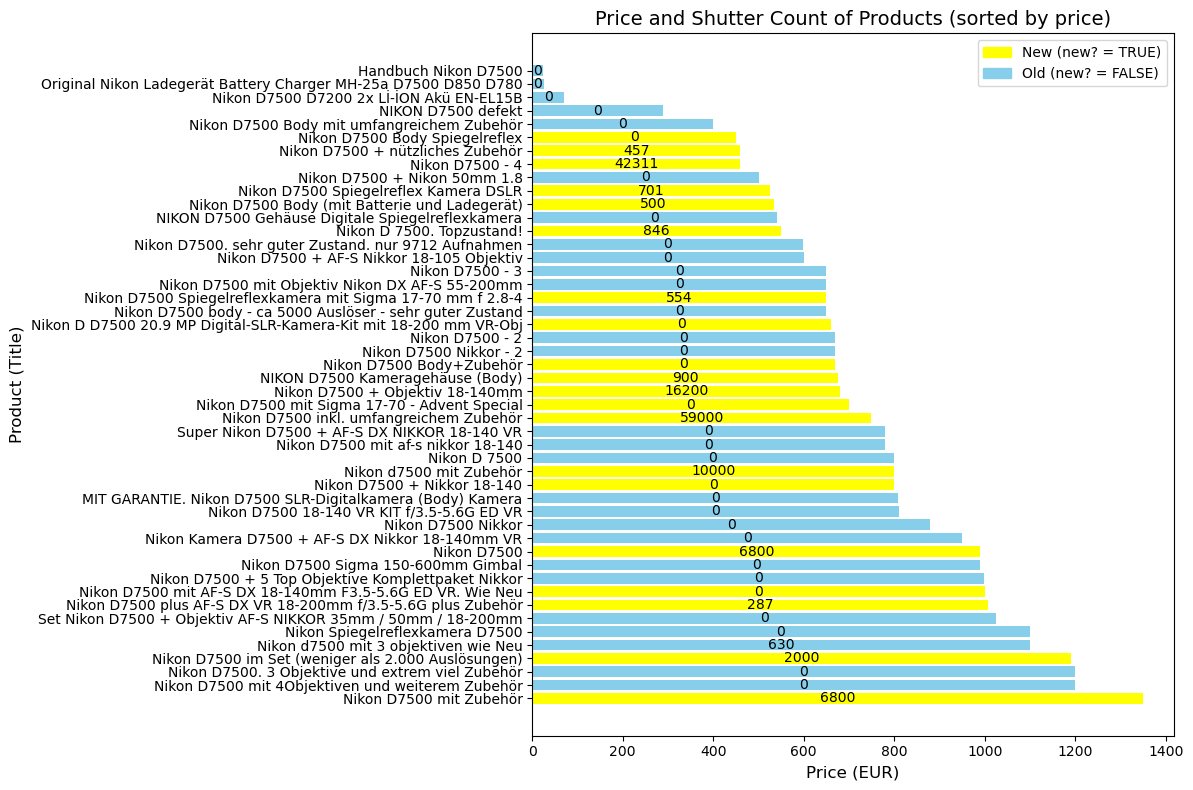

In [88]:
df_new_products = df_products_detailed[df_products_detailed['new?'] == True]

# Make sure 'shutter_count' is treated as numeric
df_products_detailed['shutter_count'] = pd.to_numeric(df_products_detailed['shutter_count'], errors='coerce')

# Sort df_products_detailed by price
df_products_detailed_sorted = df_products_detailed.sort_values(by='price', ascending=False)

# Create unique titles for products with the same name (if applicable)
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted.groupby('title').cumcount()
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted['unique_title'].apply(lambda x: f" - {x+1}" if x > 0 else "")

# Combine the original title with the unique number (if applicable)
df_products_detailed_sorted['unique_title'] = df_products_detailed_sorted['title'] + df_products_detailed_sorted['unique_title']

# Create figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Color "new" products yellow, others blue
colors = ['yellow' if is_new else 'skyblue' for is_new in df_products_detailed_sorted['new?']]

# Create horizontal bar chart (Price on X-axis, Title on Y-axis)
bars = ax.barh(df_products_detailed_sorted['unique_title'], df_products_detailed_sorted['price'], color=colors)

# Add shutter_count in the middle of each bar
for bar, shutter_count in zip(bars, df_products_detailed_sorted['shutter_count']):
    xval = bar.get_width()  # Price (X-value)
    ax.text(xval / 2, bar.get_y() + bar.get_height() / 2,  # Center the text horizontally and vertically
            f'{shutter_count}', ha='center', va='center', fontsize=10, color='black')

# Set labels for the axes and the title of the plot
ax.set_xlabel('Price (EUR)', fontsize=12)
ax.set_ylabel('Product (Title)', fontsize=12)
ax.set_title('Price and Shutter Count of Products (sorted by price)', fontsize=14)

# Create color legend for "new" products
yellow_patch = mpatches.Patch(color='yellow', label='New (new? = TRUE)')
blue_patch = mpatches.Patch(color='skyblue', label='Old (new? = FALSE)')
ax.legend(handles=[yellow_patch, blue_patch], loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


This graph shows all products sorted by price. 
In my example for the camera "Nikon D 7500" there is match between "new? = TRUE" and low values for the "shutter_count" which shows that my regex is working well :)

# Part C: Preprocessing for Feature Engineering
---

Using **spacy**, the following code snippets preprocess the description data by 

- Removing Stop Words --> not sure, if it makes sense here...
- Tokenization
- (Stemming,) Lemmatization
- Removing dots, commas
- Transforming to lower case

In [ ]:
# remove stop words function
def preprocess(text):
    doc = nlp(text)
    no_stop_words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(no_stop_words)

# apply function to data.frame
df_products_detailed['description_pp'] = df_products_detailed['description'].apply(preprocess)
df_products_detailed.head()

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Description without Stop Words saved to products_with_details.csv.')

Description without Stop Words saved to products_with_details.csv.


In [90]:
# lemmatization function
doc = nlp(df_products_detailed['description_pp'][2])

def preprocess2(text):
    doc = nlp(text)
    lemmata = [token.lemma_ for token in doc if not token.is_space]
    return lemmata

df_products_detailed['description_pp'] = df_products_detailed['description_pp'].apply(preprocess2).apply(lambda x: ' '.join(x))

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Lemmatized texts saved to products_with_details.csv.')

Lemmatized texts saved to products_with_details.csv.


In [91]:
# delete punctuation and spaces

#def preprocess3(text):
    #text = re.sub(r'[.,!?\-]+', ' ', str(text))
    #text = re.sub(r'\s+', ' ', text) # deletes extra spaces
    #text = text.strip() # deletes space at beginning and end
    #text.lower()
    #return text

def preprocess3(text):
    text = re.sub(r'(\d)[,.](\d)', r'\1<DOT>\2', text)
    text = re.sub(r'(\d)[,.](\d+)(?=\D)', r'\1<DOT>\2', text) 
    text = re.sub(r'[.,!?\-]+', ' ', text)
    text = text.replace('<DOT>', '.') # replace deleted dots and commas back to dots
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower() # lower case reduces dimension in simpler ML models
    return text

df_products_detailed['description_pp'] = df_products_detailed['description_pp'].apply(preprocess3)

# save csv file
df_products_detailed.to_csv('products_with_details.csv', index=False)
print('Texts without dots and spaces saved to products_with_details.csv.')

Texts without dots and spaces saved to products_with_details.csv.


# Part D: Feature Engineering & Model Building
---

In [125]:
# load csv trainings data
trainings_data = pd.read_csv('trainings_data.csv')
trainings_data = trainings_data[trainings_data['price'] != 0]
trainings_data = trainings_data[trainings_data['price'] < 2500]

# categorize 
def categorize(price):
    if 0 <= price <= 350:
        return 'cheap'
    elif 351 <= price <= 2500:
        return 'expensive'

# new column 'category'
trainings_data['category'] = trainings_data['price'].apply(categorize)

# preprocessing (alternative way)
def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip().lower() 

# label
trainings_data['description'] = trainings_data['description'].map(preprocess)
trainings_data['category'] = '__label__' + trainings_data['category'].astype(str)
trainings_data['category_description'] = trainings_data['category'] + ' ' + trainings_data['description']
trainings_data = trainings_data.dropna(subset=["category_description"])

trainings_data.head()

,title,price,link,description,description_pp,category,category_description
2,Nikon MS-D14 Batteriehalter,15,/s-anzeige/nikon-ms-d14-batteriehalter/2939370...,nikon ms d14 batteriehalter batterie halter ni...,nikon ms d14 batteriehalter batterie halter ni...,__label__cheap,__label__cheap nikon ms d14 batteriehalter bat...
3,Really Right Stuff Schnellwechselplatte für Ni...,49,/s-anzeige/really-right-stuff-schnellwechselpl...,really right stuff schnellwechselplatte für ni...,really right stuff schnellwechselplatte nikon ...,__label__cheap,__label__cheap really right stuff schnellwechs...
4,Really Right Stuff Schnellwechselplatte für Ni...,55,/s-anzeige/really-right-stuff-schnellwechselpl...,really right stuff schnellwechselplatte für ni...,really right stuff schnellwechselplatte nikon ...,__label__cheap,__label__cheap really right stuff schnellwechs...
5,Nikon MB-D11 Batteriegriff,60,/s-anzeige/nikon-mb-d11-batteriegriff/29394558...,nikon mb d11 batteriegriff ich verkaufe hier e...,nikon mb d11 batteriegriff verkaufen nikon mb ...,__label__cheap,__label__cheap nikon mb d11 batteriegriff ich ...
6,Nikon D3100 Kamera Spiegelreflexkamera digital...,60,/s-anzeige/nikon-d3100-kamera-spiegelreflexkam...,nikon d3100 kamera spiegelreflexkamera digital...,nikon d3100 kamera spiegelreflexkamera digital...,__label__cheap,__label__cheap nikon d3100 kamera spiegelrefle...


In [ ]:
# train test split
train, test = train_test_split(trainings_data, test_size=0.2, stratify=trainings_data['category'])

train.to_csv("trainings_data.train", columns=["category_description"], index=False, header=False)
test.to_csv("trainings_data.test", columns=["category_description"], index=False, header=False)

model = fasttext.train_supervised(input="trainings_data.train", lr=0.1, epoch=25, dim=100)
model.test("trainings_data.test")

Read 0M words
Number of words:  5894
Number of labels: 2
Progress: 100.0% words/sec/thread: 1246256 lr:  0.000000 avg.loss:  0.692293 ETA:   0h 0m 0s


(96, 0.7291666666666666, 0.7291666666666666)

In [128]:
# check if data set is balanced
class_counts = train['category'].value_counts()
print(class_counts)

category
__label__expensive    192
__label__cheap        190
Name: count, dtype: int64


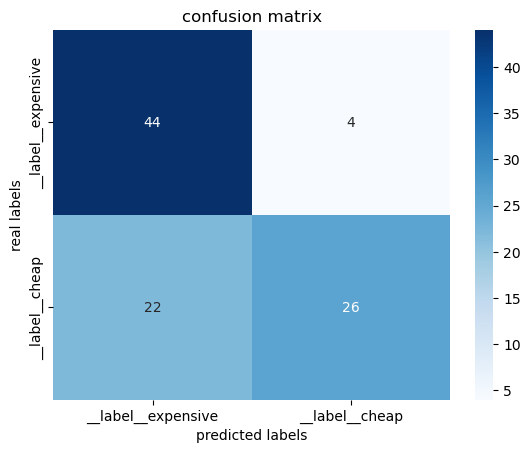

In [ ]:
# prediction of fasttext model
predictions = [model.predict(text)[0][0] for text in test['category_description']]
cm = confusion_matrix(test['category'], predictions)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.labels, yticklabels=model.labels)
plt.xlabel('predicted labels')
plt.ylabel('real labels')
plt.title('confusion matrix')
plt.show()

Result is okay as I only have a very small data set for training.

# Part E: Deal and No-Deal Detection using Trained model
---

In [119]:
# take all trainings data
trainings_data.to_csv("trainings_data_full.train", columns=["category_description"], index=False, header=False)

# train on all data
model = fasttext.train_supervised(input="trainings_data_full.train", lr=0.1, epoch=25, dim=100)

Read 0M words
Number of words:  6809
Number of labels: 2
Progress: 100.0% words/sec/thread: 1555733 lr:  0.000000 avg.loss:  0.677543 ETA:   0h 0m 0s


In [129]:
# data filtered by user input
user_data = pd.read_csv("products_with_details.csv")
user_data = user_data[user_data['price'] != 0]
user_data = user_data[user_data['price'] < 2500]

# new column 'category'
user_data['category'] = user_data['price'].apply(categorize)

# label
user_data['description'] = user_data['description'].map(preprocess)
user_data['category'] = '__label__' + user_data['category'].astype(str)
user_data['category_description'] = user_data['category'] + ' ' + trainings_data['description']
user_data = user_data.dropna(subset=["category_description"])

# prediction with new model
user_data['predicted_category'] = user_data['category_description'].apply(lambda x: model.predict(x)[0][0])

# show prediction
print(user_data[['category_description', 'predicted_category']].head())

                                category_description predicted_category
2  __label__cheap nikon ms d14 batteriehalter bat...     __label__cheap
3  __label__cheap really right stuff schnellwechs...     __label__cheap
4  __label__expensive really right stuff schnellw...     __label__cheap
5  __label__expensive nikon mb d11 batteriegriff ...     __label__cheap
6  __label__expensive nikon d3100 kamera spiegelr...     __label__cheap


In [ ]:
# check if deal or not
def check_deal(row):
    if row['predicted_category'] == "expensive" and row['category'] == "cheap":
        return True
    elif row['predicted_category'] == "cheap" and row['category'] == "expensive":
        return True
    return False
user_data['Deal'] = user_data.apply(check_deal, axis=1)

# show results
print(user_data[['category', 'predicted_category', 'Deal']].head())

             category predicted_category   Deal
2      __label__cheap     __label__cheap  False
3      __label__cheap     __label__cheap  False
4  __label__expensive     __label__cheap  False
5  __label__expensive     __label__cheap  False
6  __label__expensive     __label__cheap  False


In [131]:
# save csv file
user_data.to_csv('products_with_deals.csv', index=False)
print('Deal check saved to products_with_deals.csv.')

Deal check saved to products_with_deals.csv.


In [132]:
# count number of deals
deal_counts = user_data['Deal'].value_counts()
print(deal_counts)

Deal
False    46
Name: count, dtype: int64


The trainings data set is relatively bad. Therefore, it is hard to predict deals with it. I need a bigger data set with more cameras and less other products included!

--> Amazon Product Lists...


---
---

In [91]:
#import watermark
#print(watermark.watermark(packages="spacy"))